# Network Analysis

In [17]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import operator
import csv

### Creating a Network
Creating a network for players at Steam gaming platform based on their friend connections. The data for game genre and playing time were added as edge weight.

In [2]:
# File pathes
base_path = "D:\OneDrive\Insight\Datasets"
path_friends = base_path + "\sql_friends.csv"
path_pltime = base_path + "\sql_play_time_all.csv"

In [ ]:
# Reading friend connections
df = pd.read_csv(path_friends)
df = df.drop('Unnamed: 0', axis='columns')
df.info()

# Reading playing time
df_pltime = pd.read_csv(path_pltime, index_col='PlayerID')
df_pltime.info()

In [135]:
# Creating number of friends dataframe
df_num_friends = df.groupby(['steamid_a'], as_index=False).count()
df_num_friends.columns = ['PlayerID', 'Num_Friends']
df_num_friends2 = df.groupby(['steamid_b'], as_index=False).count()
df_num_friends2.columns = ['PlayerID', 'Num_Friends']
df_num_friends = df_num_friends.append(df_num_friends2)
df_num_friends = df_num_friends.drop_duplicates(subset=['PlayerID'])
df_num_friends.set_index(['PlayerID'], inplace=True)
df_num_friends.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615208 entries, 76561197960265744 to 76561198112335642
Data columns (total 1 columns):
Num_Friends    int64
dtypes: int64(1)
memory usage: 39.9 MB


In [4]:
# Creating an undirected and unweighted network
G = nx.from_pandas_edgelist(df, source='steamid_a', target='steamid_b', create_using=nx.Graph)
print('Numer of nodes:',G.number_of_nodes())
print('Numer of edges:',G.number_of_edges())
# Saving the network as a edgelist file
nx.write_edgelist(G, path=base_path + "\graph.edgelist")

Numer of nodes: 2615208
Numer of edges: 5886369


In [ ]:
# Creating weighted network for each genre
# the edge weight is based on the ratio of total playing time of two connected player in a specific genre
# the playing time is normalized based on the total playing time of players since joining the platform
G_w = G.__class__()
G_w.add_nodes_from(G)
G_w.add_edges_from(G.edges)

list_genre = ['Action', 'Free to Play', 'Strategy', 'Adventure', 'Indie', 'RPG', 'Casual', \
              'Simulation', 'Racing', 'Massively Multiplayer','Sports', 'Early Access']
players = list(df_pltime[df_pltime['Total']!=0].index)
for genre in list_genre:
    i=0
    print(genre)
    G_w.edges.data('weight', default=0)
    for a in players:
        i+=1
        # printing progress
        if (i % 1000 == 0) : print('%0.2f' % (i/len(players)*100))
        # computing the weight of edge connections
        for b in list(G.neighbors(a)):
            pltime_genre_a = df_pltime.loc[a][genre]
            pltime_total_a = df_pltime.loc[a]['Total']
            pltime_genre_b = df_pltime.loc[b][genre]
            pltime_total_b = df_pltime.loc[b]['Total']
            w = (pltime_genre_a + pltime_genre_b)/(pltime_total_a + pltime_total_b)
            G_w.add_weighted_edges_from([(a,b,w)])
    nx.write_edgelist(G_w, path=base_path + "\graph_w_%s.edgelist" % genre)

### Analysis of Structural Properties
Performing network analysis

**Node degree and degree distribution**

In [ ]:
# Calculaitng minimum, maximum, and average degree
degrees = [deg for node, deg in nx.degree(G)]
print('Minimum degree:',np.min(degrees))
print('Maximum degree:',np.max(degrees))
print('Average degree:',np.mean(degrees))

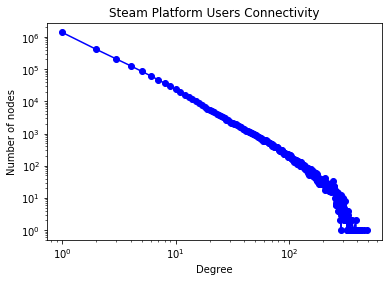

In [29]:
# Calculating degree distribution (how edges are distributed among nodes)
degrees = dict(G.degree()) 
count = list(Counter(degrees.values()).items()) 
count.sort(key=lambda x:x[0])
count = np.array(count)

# Plotting logarithmic histogram
_ = plt.loglog(count.T[0],count.T[1],'bo-')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Number of nodes')
_ = plt.title('Steam Platform Users Connectivity')
plt.savefig('degree_distribution.png', dpi=300)

**Clustering coefficient** is a measure of how much nodes in a graph tend to cluster together. It is the proportion of links between the vertices within its neighbourhood divided by the number of links that could possibly exist between them.

In [60]:
# Maximum clustering coeffiecient
clus_coef_max = np.max([x for key, x in nx.clustering(G).items()])
print('Maximum clustering coefficient:',clus_coef_max)

# Average clustering coefficient for the graph
clus_coef_avg = nx.average_clustering(G)
print('Average clustering coefficient:',clus_coef_avg)

Maximum clustering coefficient: 1.0
Average clustering coefficient: 0.09469454989045165


**Centrality** identifes the most important vertices within a graph. The related methods are degree centrality and eigenvector centrality. Centrality should not be confused with node influence metrics such as accessibility and expected force.<br>
This is the main analysis for identifying the relative popularity of players for targeting advertisement of a newely developed game in a specific genre.

In [ ]:
# Degree centrality (defined as the number of links incident upon a node)
deg_cent = nx.degree_centrality(G)
players_deg_cent = sorted(deg_cent.items(), key=operator.itemgetter(1), reverse=True)
players_deg_cent = pd.DataFrame(players_deg_cent, columns=['PlayerID','Degree centrality'])
players_deg_cent.to_csv(base_path + "\players_deg_cent.csv", index=False)
print('Top players based on degree centrality:\n',players_deg_cent[0:3],'\n')

# Eigenvector centrality (defined as a relative score of a node which is connected to many nodes with high scores)
list_genre = ['Action', 'Free to Play', 'Strategy', 'Adventure', 'Indie', 'RPG', 'Casual', \
              'Simulation', 'Racing', 'Massively Multiplayer','Sports', 'Early Access']
print('Top players based on eigenvector centrality:\n')
for genre in list_genre:
    print(genre)
    G_w = nx.read_edgelist(base_path + "\graph_w_%s.edgelist" % genre)
    eigen_cent = nx.eigenvector_centrality_numpy(G_w, weight='weight', max_iter=50, tol=1.0e-3)
    players_eigen_cent = sorted(eigen_cent.items(), key=operator.itemgetter(1), reverse=True)
    players_eigen_cent = pd.DataFrame(players_eigen_cent, columns=['PlayerID','Eigenvector centrality'])
    players_eigen_cent.to_csv(base_path + "\players_eigen_cent_%s.csv" % genre, index=False)
    print(players_eigen_cent[0:3],'\n')

**Degree assortativity** is Pearson correlation coefficient of graph (Eq. 21 of Newman, Mixing patterns in networks, Physical Review E, 67 026126, 2003). The output lies in the range of -1< r <1 with -1 indicating perferct disassortivity where high degree nodes tend to attach to low degree nodes.

In [6]:
# Computing degree assortativity of graph
deg_assor = nx.degree_assortativity_coefficient(G)
print('Degree assortativity of graph:',deg_assor)

Degree assortativity of graph: -0.23649264108806717


### Subgraphs
Creating random subgraphs from the whole network for quick comparision of centrality methods

In [ ]:
# Randomly selecting n number of players including their friend connections
n = 10
steamids = list(df['steamid_a'].unique())
players = [steamids[np.random.randint(0,len(steamids))] for i in np.arange(n)]

# Creating an unweighted subgraph
nodes = []
for player in players:
    nodes.append(player)
    nodes.extend(list(G.neighbors(player)))
G_sub = G.subgraph(nodes)
nx.write_edgelist(G_sub, path=base_path + "\subgraph.edgelist")
print(G_sub.number_of_nodes())


# Randomly chosing position of nodes for visualisation
pos = dict()
pos.update((n, list(np.random.random(2))) for i, n in enumerate(G_sub.nodes))
w = csv.writer(open(base_path + "\subgraph_node_positions.csv", "w"))
for key, val in pos.items():
    w.writerow([key, val])

# Creating a weighted subgraph
nodes = []
for player in players:
    nodes.append(player)
    nodes.extend(list(G_w.neighbors(player)))
G_w_sub = G_w.subgraph(nodes)
print(G_w_sub.number_of_nodes())
nx.write_edgelist(G_w_sub, path=base_path + "\subgraph_w.edgelist")

### Various Centrality Methods
Comparing the resutls of various centrality methods for subgraphs as a reference. For the application of current project, only degree and eigenvector centrality methods give us a reasonable insight about the network of video game players.

In [27]:
# Degree centrality
deg_cent_sub = nx.degree_centrality(G_sub)

# Eigenvector centrality
eigen_cent_sub = nx.eigenvector_centrality_numpy(G_w_sub, weight='weight', max_iter=50, tol=1.0e-3)

# Betweenness centrality
betw_cent_sub = betweenness_centrality(G_w_sub, normalized=True, weight='weight')

# Closeness centrality
close_cent_sub = closeness_centrality(G_w_sub, normalized=True)

# Harmonic centrality
harm_cent_sub = harmonic_centrality(G_w_sub)

# Katz centrality
katz_cent_sub = katz_centrality(G_w_sub, max_iter=50, tol=1e-03, normalized=True, weight='weight')

### Network Visualization

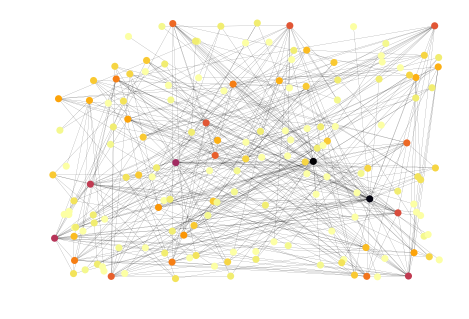

In [25]:
# Drawing the graph
color_value = list(deg_cent_sub.values())
options = {
    'node_color': color_value,
    'cmap' : 'inferno_r', #'YlOrRd', #YlGnBu
    'vmin' : min(color_value),
    'vmax' : max(color_value),
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'pos' : pos
    'width': 0.1,
}

nx.draw(G_sub, **options)
plt.savefig('Network Graph - Degree Centrality.png', dpi=300)

In [ ]:
color_value = list(eigen_cent_sub.values())
options['node_color'] = color_value
options['width'] = [x/2 for x in list(nx.get_edge_attributes(G_w_sub,'weight').values())]

nx.draw(G_w_sub, **options)
plt.savefig('Network Graph - Eigenvector Centrality.png', dpi=300)

In [ ]:
color_value = list(betw_cent_sub.values())
options['node_color'] = color_value

nx.draw(G_w_sub, **options)
plt.savefig('Network Graph - Betweenness Centrality.png', dpi=300)

In [ ]:
color_value = list(close_cent_sub.values())
options['node_color'] = color_value

nx.draw(G_w_sub, **options)
plt.savefig('Network Graph - Closeness Centrality.png', dpi=300)

In [ ]:
color_value = list(harm_cent_sub.values())
options['node_color'] = color_value

nx.draw(G_w_sub, **options)
plt.savefig('Network Graph - Harmonic Centrality.png', dpi=300)

In [ ]:
color_value = list(katz_cent_sub.values())
options['node_color'] = color_value

nx.draw(G_w_sub, **options)
plt.savefig('Network Graph - Katz Centrality.png', dpi=300)